# Catalyzing Social Interactions in Mixed Reality using ML Recommendation Systems

Columbia University in the City of New York

Sparsh Srivastava (ss6381), Rohan Arora (ra3091)


In [ ]:
import joblib
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

from sklearn.compose import ColumnTransformer
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
directory = "/content/drive/My Drive/Goals/Academic researcher/[Seminar] Topics in Computer Science/Final paper/"  # sparsh
try:
  open(directory + 'scenario_builder/scenarios.csv', 'r')
except Exception:
  directory = "/content/drive/MyDrive/coms_6156/final/" #rohan

In [ ]:
# We define a user class that reads all of the data from
# [Part 1] Social Interactions Study, where we had asked
# survey participants to fill out their information, after
# acquiring all of the necessary consent required by the
# Prolific platform.

class User:
  def __init__(self, age, gender, height, hair_type, hair_color, has_tattoos,
            education, is_student, is_in_workforce, industry,
            favorite_hobby, favorite_interest, music_genre, personality,
            listen_or_speak, favorite_social_media, music_listen_time,
            group_size, clothing_athletic, clothing_casual,
            clothing_trendy, clothing_formal, clothing_designer,
            clothing_eyeglasses, clothing_sunglasses,
            clothing_luxury_watch, clothing_smart_watch, clothing_hat,
            clothing_necklace, clothing_rings, clothing_earrings):

    self.age = age
    self.gender = gender
    self.height = height
    self.hair_type = hair_type
    self.hair_color = hair_color
    self.has_tattoos = has_tattoos
    self.education = education
    self.is_student = is_student
    self.is_in_workforce = is_in_workforce
    self.industry = industry
    self.favorite_hobby = favorite_hobby
    self.favorite_interest = favorite_interest
    self.favorite_social_media = favorite_social_media
    self.music_genre = music_genre
    self.music_listen_time = music_listen_time
    self.personality = personality
    self.listen_or_speak = listen_or_speak
    self.group_size = group_size

    # Clothing (multi-select question, translated to binary/boolean
    # features).
    self.clothing_athletic = clothing_athletic
    self.clothing_casual = clothing_casual
    self.clothing_trendy = clothing_trendy
    self.clothing_formal = clothing_formal
    self.clothing_designer = clothing_designer
    self.clothing_eyeglasses = clothing_eyeglasses
    self.clothing_sunglasses = clothing_sunglasses
    self.clothing_luxury_watch = clothing_luxury_watch
    self.clothing_smart_watch = clothing_smart_watch
    self.clothing_hat = clothing_hat
    self.clothing_necklace = clothing_necklace
    self.clothing_rings = clothing_rings
    self.clothing_earrings = clothing_earrings


In [ ]:
class Scenario:
    def __init__(self, location, weather, human_congestion_level,
                 human_noise_level, non_human_noise_level, candidate_occluded,
                 gaze_self_to_candidate, gaze_candidate_to_self, proximity,
                 day_of_week, time_of_day):
        self.location = location
        self.weather = weather
        self.human_congestion_level = human_congestion_level
        self.human_noise_level = human_noise_level
        self.non_human_noise_level = non_human_noise_level
        self.candidate_occluded = candidate_occluded
        self.gaze_self_to_candidate = gaze_self_to_candidate if not \
                                      candidate_occluded else False
        self.gaze_candidate_to_self = gaze_candidate_to_self
        self.proximity = proximity
        self.day_of_week = day_of_week
        self.time_of_day = time_of_day


In [ ]:
def get_empty_interaction_dict():
    interaction = {
        # Self (not dependent on location).
        'self_age': [],
        'self_gender': [],
        'self_height': [],
        'self_hair_type': [],
        'self_hair_color': [],
        'self_tattoos': [],
        'self_education': [],
        'self_student': [],
        'self_workforce': [],
        'self_industry': [],
        'self_hobby': [],  # Favorite hobby.
        'self_interest': [],  # Favorite interest.
        'self_music_genre': [],
        'self_personality': [],
        'self_conversational_intensity': [],
        'self_social_media': [],  # Favorite social media.
        'self_music_listen_time': [],

        # Candidate (not dependent on location).
        'candidate_age': [],
        'candidate_gender': [],
        'candidate_height': [],
        'candidate_hair_type': [],
        'candidate_hair_color': [],
        'candidate_tattoos': [],
        'candidate_education': [],
        'candidate_student': [],
        'candidate_workforce': [],
        'candidate_industry': [],
        'candidate_hobby': [],  # Favorite hobby.
        'candidate_interest': [],  # Favorite interest.
        'candidate_music_genre': [],
        'candidate_personality': [],
        'candidate_conversational_intensity': [],
        'candidate_social_media': [],  # Favorite social media.
        'candidate_music_listen_time': [],

        # Environment (non-deterministic).
        'location': [],
        'weather': [],
        'human_congestion_level': [],
        'human_noise_level': [],
        'non_human_noise_level': [],
        'candidate_occluded': [],
        'gaze_self_to_candidate': [],
        'gaze_candidate_to_self': [],
        'proximity': [],

        # Environment (deterministic, dependent on location).
        'day_of_week': [],  # Based on candidate.
        'time_of_day': [],  # Based on candidate.

        # Self (dependent on location).
        'self_group_size': [],
        'self_clothing_athletic': [],  # Deterministic.
        'self_clothing_casual': [],  # Deterministic.
        'self_clothing_trendy': [],  # Deterministic.
        'self_clothing_formal': [],  # Deterministic.
        'self_clothing_designer': [],  # Deterministic.
        'self_clothing_hat': [],  # Deterministic.
        'self_clothing_eyeglasses': [],  # Deterministic.
        'self_clothing_sunglasses': [],  # Deterministic.
        'self_clothing_necklace': [],  # Deterministic.
        'self_clothing_luxury_watch': [],  # Deterministic.
        'self_clothing_rings': [],  # Deterministic.
        'self_clothing_earrings': [],  # Deterministic.
        'self_clothing_smart_watch': [],  # Deterministic.

        # Candidate (dependent on location).
        'candidate_group_size': [],
        'candidate_clothing_athletic': [],  # Non-deterministic.
        'candidate_clothing_casual': [],  # Non-deterministic.
        'candidate_clothing_trendy': [],  # Non-deterministic.
        'candidate_clothing_formal': [],  # Non-deterministic.
        'candidate_clothing_designer': [],  # Non-deterministic.
        'candidate_clothing_hat': [],  # Non-deterministic.
        'candidate_clothing_eyeglasses': [],  # Non-deterministic.
        'candidate_clothing_sunglasses': [],  # Non-deterministic.
        'candidate_clothing_necklace': [],  # Non-deterministic.
        'candidate_clothing_luxury_watch': [],  # Non-deterministic.
        'candidate_clothing_rings': [],  # Non-deterministic.
        'candidate_clothing_earrings': [],  # Non-deterministic.
        'candidate_clothing_smart_watch': [],  # Non-deterministic.

        # Output label.
        'self_decision': [],
    }

    return interaction


In [ ]:
def feet_inches_to_inches(string):
    split = string.split('ft')
    feet = split[0].strip()
    inches = split[1].strip()
    inches = inches.split('in')
    inches = inches[0].strip()
    return 12 * int(feet) + int(inches)


In [ ]:
def append_scenario(interaction, scenario):
    interaction['location'].append(scenario.location)
    interaction['weather'].append(scenario.weather)
    interaction['human_congestion_level'].append(scenario.human_congestion_level)
    interaction['human_noise_level'].append(scenario.human_noise_level)
    interaction['non_human_noise_level'].append(scenario.non_human_noise_level)
    interaction['candidate_occluded'].append(scenario.candidate_occluded)
    interaction['gaze_self_to_candidate'].append(scenario.gaze_self_to_candidate)
    interaction['gaze_candidate_to_self'].append(scenario.gaze_candidate_to_self)
    interaction['proximity'].append(scenario.proximity)
    interaction['day_of_week'].append(scenario.day_of_week)
    interaction['time_of_day'].append(scenario.time_of_day)


In [ ]:
def append_clothing(interaction, user, is_self):
    key_prefix = 'self_'
    if not is_self:
      key_prefix = 'candidate_'

    interaction[f'{key_prefix}clothing_athletic'].append(user.clothing_athletic)
    interaction[f'{key_prefix}clothing_casual'].append(user.clothing_casual)
    interaction[f'{key_prefix}clothing_trendy'].append(user.clothing_trendy)
    interaction[f'{key_prefix}clothing_formal'].append(user.clothing_formal)
    interaction[f'{key_prefix}clothing_designer'].append(user.clothing_designer)
    interaction[f'{key_prefix}clothing_hat'].append(user.clothing_hat)
    interaction[f'{key_prefix}clothing_eyeglasses'].append(user.clothing_eyeglasses)
    interaction[f'{key_prefix}clothing_sunglasses'].append(user.clothing_sunglasses)
    interaction[f'{key_prefix}clothing_necklace'].append(user.clothing_necklace)
    interaction[f'{key_prefix}clothing_luxury_watch'].append(user.clothing_luxury_watch)
    interaction[f'{key_prefix}clothing_rings'].append(user.clothing_rings)
    interaction[f'{key_prefix}clothing_earrings'].append(user.clothing_earrings)
    interaction[f'{key_prefix}clothing_smart_watch'].append(user.clothing_smart_watch)


In [ ]:
def create_interaction(user_self, user_candidate, scenario, expected_decision):
    interaction = get_empty_interaction_dict()

    # Self (not dependent on location).
    interaction['self_age'].append(int(user_self.age))
    interaction['self_gender'].append(user_self.gender)
    interaction['self_height'].append(feet_inches_to_inches(user_self.height))
    interaction['self_hair_type'].append(user_self.hair_type)
    interaction['self_hair_color'].append(user_self.hair_color)
    interaction['self_tattoos'].append(user_self.has_tattoos)
    interaction['self_education'].append(user_self.education)
    interaction['self_student'].append(user_self.is_student)
    interaction['self_workforce'].append(user_self.is_in_workforce)
    interaction['self_industry'].append(user_self.industry)
    interaction['self_hobby'].append(user_self.favorite_hobby)
    interaction['self_interest'].append(user_self.favorite_interest)
    interaction['self_music_genre'].append(user_self.music_genre)
    interaction['self_personality'].append(user_self.personality)
    interaction['self_conversational_intensity'].append(user_self.listen_or_speak)
    interaction['self_social_media'].append(user_self.favorite_social_media)
    interaction['self_music_listen_time'].append(user_self.music_listen_time)

    # Candidate (not dependent on location).
    interaction['candidate_age'].append(int(user_candidate.age))
    interaction['candidate_gender'].append(user_candidate.gender)
    interaction['candidate_height'].append(feet_inches_to_inches(user_candidate.height))
    interaction['candidate_hair_type'].append(user_candidate.hair_type)
    interaction['candidate_hair_color'].append(user_candidate.hair_color)
    interaction['candidate_tattoos'].append(user_candidate.has_tattoos)
    interaction['candidate_education'].append(user_candidate.education)
    interaction['candidate_student'].append(user_candidate.is_student)
    interaction['candidate_workforce'].append(user_candidate.is_in_workforce)
    interaction['candidate_industry'].append(user_candidate.industry)
    interaction['candidate_hobby'].append(user_candidate.favorite_hobby)
    interaction['candidate_interest'].append(user_candidate.favorite_interest)
    interaction['candidate_music_genre'].append(user_candidate.music_genre)
    interaction['candidate_personality'].append(user_candidate.personality)
    interaction['candidate_conversational_intensity'].append(user_candidate.listen_or_speak)
    interaction['candidate_social_media'].append(user_candidate.favorite_social_media)
    interaction['candidate_music_listen_time'].append(user_candidate.music_listen_time)

    # Environment (non-deterministic) & Candidate clothing (non-deterministic).
    append_scenario(interaction, scenario)

    # Self (dependent on location).
    interaction['self_group_size'].append(user_self.group_size)
    append_clothing(interaction, user_self, True)

    # Candidate (dependent on location).
    interaction['candidate_group_size'].append(user_candidate.group_size)
    append_clothing(interaction, user_candidate, False)

    # Output label.
    interaction['self_decision'].append(expected_decision)

    return interaction


In [ ]:
rohan = User(
    age = '25',
    gender = 'Male.',
    height = '5 ft 8 in',
    hair_type = 'Short (curly / wavy).',
    hair_color = 'Black',
    has_tattoos = 'No',
    education = "Bachelor's Degree.",
    is_student = 'No.',
    is_in_workforce = 'Yes.',
    industry = 'Professional & Business Services.',
    favorite_hobby = 'Games (e.g., board games, video games, puzzles).',
    favorite_interest = 'Animals and nature.',
    favorite_social_media = 'YouTube',
    music_genre = 'Metal',
    music_listen_time = '2 - 3 hours.',
    personality = 'Introvert.',
    listen_or_speak = 'I tend to listen more (to what others are saying).',
    group_size = 'I typically go alone.',
    clothing_athletic = False,
    clothing_casual = False,
    clothing_trendy = False,
    clothing_formal = False,
    clothing_designer = False,
    clothing_eyeglasses = False,
    clothing_sunglasses = False,
    clothing_luxury_watch = False,
    clothing_smart_watch = False,
    clothing_hat = False,
    clothing_necklace = False,
    clothing_rings = False,
    clothing_earrings = False,
)


In [ ]:
sparsh = User(
    age = '25',
    gender = 'Male.',
    height = '6 ft 0 in',
    hair_type = 'Short (straight).',
    hair_color = 'Black',
    has_tattoos = 'No',
    education = "Bachelor's Degree.",
    is_student = 'No.',
    is_in_workforce = 'Yes.',
    industry = 'Arts & Entertainment (self-employed)/on disability',
    favorite_hobby = 'Creative arts (e.g., painting, drawing, music, writing).',
    favorite_interest = 'Arts and literature.',
    favorite_social_media = 'TikTok',
    music_genre = 'Rock (Classic Rock, Alternative, Indie, etc.)',
    music_listen_time = '2 - 3 hours.',
    personality = 'Extrovert.',
    listen_or_speak = 'I tend to speak more.',
    group_size = '2 - 3 other people.',
    clothing_athletic = False,
    clothing_casual = False,
    clothing_trendy = False,
    clothing_formal = False,
    clothing_designer = False,
    clothing_eyeglasses = False,
    clothing_sunglasses = False,
    clothing_luxury_watch = False,
    clothing_smart_watch = False,
    clothing_hat = False,
    clothing_necklace = False,
    clothing_rings = False,
    clothing_earrings = False
)


In [ ]:
scenario = Scenario(
    location = 'Gym',
    weather = 'cloudy',
    human_congestion_level = True,
    human_noise_level = 'quiet',
    non_human_noise_level = 'quiet',
    candidate_occluded = False,
    gaze_self_to_candidate = True,
    gaze_candidate_to_self = True,
    proximity = 'near',
    day_of_week = 'Weekend (Saturday, Sunday).',
    time_of_day = 'Morning (before 12 PM).',
)


In [ ]:
expected_decision = 'Accept'
interaction = create_interaction(rohan, sparsh, scenario, expected_decision)
# interaction = create_interaction(sparsh, rohan, scenario, expected_decision)
df = pd.DataFrame(interaction)
print(df.shape)
print(df['self_decision'][0])

(1, 74)
Accept


In [ ]:
# Model loading
model = joblib.load(directory + 'model/demo_models/demo_best_accuracy_combination_model_accept_reject.joblib')

In [ ]:
# Preprocessing for model using all features (includes user, MR, and right-time features).
features = ['self_age', 'self_gender', 'self_height', 'self_hair_type', 'self_hair_color',
            'self_tattoos', 'self_education', 'self_student', 'self_workforce', 'self_industry',
            'self_hobby', 'self_interest', 'self_music_genre', 'self_personality', 'self_conversational_intensity',
            'self_social_media', 'self_music_listen_time', 'candidate_age', 'candidate_gender', 'candidate_height',
            'candidate_hair_type', 'candidate_hair_color', 'candidate_tattoos', 'candidate_education', 'candidate_student',
            'candidate_workforce', 'candidate_industry', 'candidate_hobby', 'candidate_interest', 'candidate_music_genre',
            'candidate_personality', 'candidate_conversational_intensity', 'candidate_social_media', 'candidate_music_listen_time', 'location',
            'weather', 'human_congestion_level', 'human_noise_level', 'non_human_noise_level', 'candidate_occluded',
            'gaze_self_to_candidate', 'gaze_candidate_to_self', 'proximity', 'day_of_week', 'time_of_day',
            'self_group_size', 'self_clothing_athletic', 'self_clothing_casual', 'self_clothing_trendy', 'self_clothing_formal',
            'self_clothing_designer', 'self_clothing_hat', 'self_clothing_eyeglasses', 'self_clothing_sunglasses', 'self_clothing_necklace',
            'self_clothing_luxury_watch', 'self_clothing_rings', 'self_clothing_earrings', 'self_clothing_smart_watch', 'candidate_group_size',
            'candidate_clothing_athletic', 'candidate_clothing_casual', 'candidate_clothing_trendy', 'candidate_clothing_formal', 'candidate_clothing_designer',
            'candidate_clothing_hat', 'candidate_clothing_eyeglasses', 'candidate_clothing_sunglasses', 'candidate_clothing_necklace', 'candidate_clothing_luxury_watch',
            'candidate_clothing_rings', 'candidate_clothing_earrings', 'candidate_clothing_smart_watch']
X = df[features]
transformer = ColumnTransformer(
  transformers=[('onehot', OneHotEncoder(), ['self_gender', 'self_hair_type', 'self_hair_color',
    'self_tattoos', 'self_education', 'self_student', 'self_workforce', 'self_industry',
    'self_hobby', 'self_interest', 'self_music_genre', 'self_personality', 'self_conversational_intensity',
    'self_social_media', 'self_music_listen_time', 'candidate_gender',
    'candidate_hair_type', 'candidate_hair_color', 'candidate_tattoos', 'candidate_education', 'candidate_student',
    'candidate_workforce', 'candidate_industry', 'candidate_hobby', 'candidate_interest', 'candidate_music_genre',
    'candidate_personality', 'candidate_conversational_intensity', 'candidate_social_media', 'candidate_music_listen_time', 'location',
    'weather', 'human_congestion_level', 'human_noise_level', 'non_human_noise_level', 'candidate_occluded',
    'gaze_self_to_candidate', 'gaze_candidate_to_self', 'proximity', 'day_of_week', 'time_of_day',
    'self_group_size', 'self_clothing_athletic', 'self_clothing_casual', 'self_clothing_trendy', 'self_clothing_formal',
    'self_clothing_designer', 'self_clothing_hat', 'self_clothing_eyeglasses', 'self_clothing_sunglasses', 'self_clothing_necklace',
    'self_clothing_luxury_watch', 'self_clothing_rings', 'self_clothing_earrings', 'self_clothing_smart_watch', 'candidate_group_size',
    'candidate_clothing_athletic', 'candidate_clothing_casual', 'candidate_clothing_trendy', 'candidate_clothing_formal', 'candidate_clothing_designer',
    'candidate_clothing_hat', 'candidate_clothing_eyeglasses', 'candidate_clothing_sunglasses', 'candidate_clothing_necklace', 'candidate_clothing_luxury_watch',
    'candidate_clothing_rings', 'candidate_clothing_earrings', 'candidate_clothing_smart_watch'])],
  remainder='passthrough'
)

pretrain_X_df = pd.read_csv(directory + 'model/saved_models/X_mr_df.csv')
transformer.fit(pretrain_X_df)

X_transformed = transformer.transform(X)
y = df['self_decision']


In [ ]:
# Prediction and evaluation for combination model.
y_pred = model.predict(X_transformed)
print("Predicted:", y_pred[0])
print("Expected:", y[0])
# accuracy = accuracy_score(y, y_pred)
# print("Accuracy:", accuracy)


Predicted: Accept
Expected: Accept


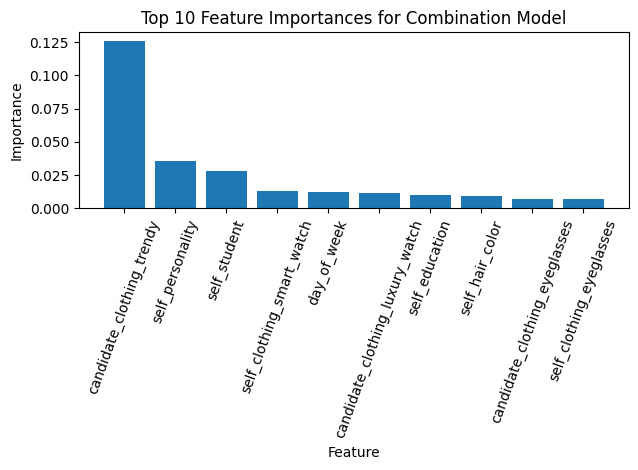

In [ ]:
# plot the feature importances for the combination model.
feature_importances = model.feature_importances_
feature_importance_names = sorted(zip(feature_importances, features), reverse=True)
top_10_importances = feature_importance_names[:10]
sorted_importances, feature_labels = zip(*top_10_importances)
plt.bar(feature_labels, sorted_importances)
plt.xlabel('Feature')
plt.ylabel('Importance')
plt.title('Top 10 Feature Importances for Combination Model')
plt.xticks(rotation=70)  # Rotate x-axis labels for better readability with long names
plt.tight_layout()
plt.show()

/usr/local/lib/python3.10/dist-packages/sklearn/base.py:318: UserWarning: Trying to unpickle estimator DecisionTreeClassifier from version 0.24.2 when using version 1.2.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:318: UserWarning: Trying to unpickle estimator RandomForestClassifier from version 0.24.2 when using version 1.2.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(


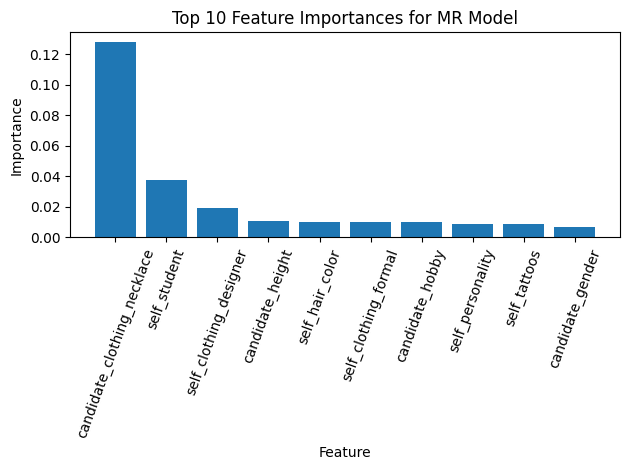

In [ ]:
# load and plot the feature importances for the MR model
model = joblib.load(directory + 'model/demo_models/demo_accept_reject_mr_20240424-153305547789.joblib')

features = ['self_age', 'self_gender', 'self_height', 'self_hair_type', 'self_hair_color',
            'self_tattoos', 'self_education', 'self_student', 'self_workforce', 'self_industry',
            'self_hobby', 'self_interest', 'self_music_genre', 'self_personality', 'self_conversational_intensity',
            'self_social_media', 'self_music_listen_time', 'candidate_age', 'candidate_gender', 'candidate_height',
            'candidate_hair_type', 'candidate_hair_color', 'candidate_tattoos', 'candidate_education', 'candidate_student',
            'candidate_workforce', 'candidate_industry', 'candidate_hobby', 'candidate_interest', 'candidate_music_genre',
            'candidate_personality', 'candidate_conversational_intensity', 'candidate_social_media', 'candidate_music_listen_time',
            'human_congestion_level', 'candidate_occluded',
            'gaze_self_to_candidate', 'gaze_candidate_to_self', 'proximity',
            'self_group_size', 'self_clothing_athletic', 'self_clothing_casual', 'self_clothing_trendy', 'self_clothing_formal',
            'self_clothing_designer', 'self_clothing_hat', 'self_clothing_eyeglasses', 'self_clothing_sunglasses', 'self_clothing_necklace',
            'self_clothing_luxury_watch', 'self_clothing_rings', 'self_clothing_earrings', 'self_clothing_smart_watch', 'candidate_group_size',
            'candidate_clothing_athletic', 'candidate_clothing_casual', 'candidate_clothing_trendy', 'candidate_clothing_formal', 'candidate_clothing_designer',
            'candidate_clothing_hat', 'candidate_clothing_eyeglasses', 'candidate_clothing_sunglasses', 'candidate_clothing_necklace', 'candidate_clothing_luxury_watch',
            'candidate_clothing_rings', 'candidate_clothing_earrings', 'candidate_clothing_smart_watch']
feature_importances = model.feature_importances_
feature_importance_names = sorted(zip(feature_importances, features), reverse=True)
top_10_importances = feature_importance_names[:10]
sorted_importances, feature_labels = zip(*top_10_importances)
plt.bar(feature_labels, sorted_importances)
plt.xlabel('Feature')
plt.ylabel('Importance')
plt.title('Top 10 Feature Importances for MR Model')
plt.xticks(rotation=70)  # Rotate x-axis labels for better readability with long names
plt.tight_layout()
plt.show()

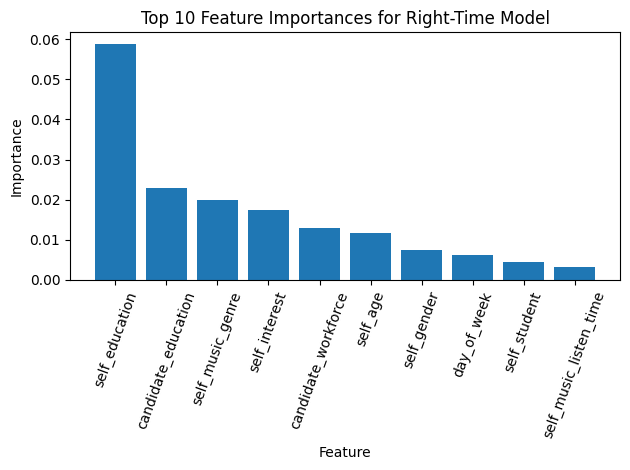

In [ ]:
# load and plot the feature importances for the right-time model
model = joblib.load(directory + 'model/demo_models/demo_accept_reject_right_time_20240424-124130044290.joblib')

features = [
  'self_age', 'self_gender',
  'self_education', 'self_student', 'self_workforce', 'self_industry',
  'self_hobby', 'self_interest', 'self_music_genre', 'self_personality',
  'self_social_media', 'self_music_listen_time', 'candidate_age', 'candidate_gender',
  'candidate_education', 'candidate_student',
  'candidate_workforce', 'candidate_industry', 'candidate_hobby', 'candidate_interest', 'candidate_music_genre',
  'candidate_personality', 'candidate_social_media', 'candidate_music_listen_time', 'location',
  'weather', 'human_noise_level', 'non_human_noise_level',
  'day_of_week', 'time_of_day'
]
feature_importances = model.feature_importances_
feature_importance_names = sorted(zip(feature_importances, features), reverse=True)
top_10_importances = feature_importance_names[:10]
sorted_importances, feature_labels = zip(*top_10_importances)
plt.bar(feature_labels, sorted_importances)
plt.xlabel('Feature')
plt.ylabel('Importance')
plt.title('Top 10 Feature Importances for Right-Time Model')
plt.xticks(rotation=70)  # Rotate x-axis labels for better readability with long names
plt.tight_layout()
plt.show()

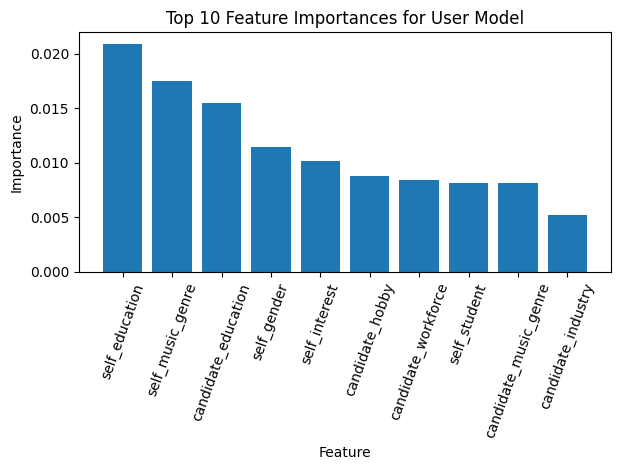

In [ ]:
# load and plot the feature importances for the user model
model = joblib.load(directory + 'model/demo_models/demo_accept_reject_user_20240424-205926578758.joblib')

features = [
  'self_age', 'self_gender',
  'self_education', 'self_student', 'self_workforce', 'self_industry',
  'self_hobby', 'self_interest', 'self_music_genre', 'self_personality',
  'self_social_media', 'self_music_listen_time', 'candidate_age', 'candidate_gender',
  'candidate_education', 'candidate_student',
  'candidate_workforce', 'candidate_industry', 'candidate_hobby', 'candidate_interest', 'candidate_music_genre',
  'candidate_personality', 'candidate_social_media', 'candidate_music_listen_time'
]
feature_importances = model.feature_importances_
feature_importance_names = sorted(zip(feature_importances, features), reverse=True)
top_10_importances = feature_importance_names[:10]
sorted_importances, feature_labels = zip(*top_10_importances)
plt.bar(feature_labels, sorted_importances)
plt.xlabel('Feature')
plt.ylabel('Importance')
plt.title('Top 10 Feature Importances for User Model')
plt.xticks(rotation=70)  # Rotate x-axis labels for better readability with long names
plt.tight_layout()
plt.show()